In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OlistECommerceAnalysis") \
    .getOrCreate()

print("PySpark installed and SparkSession created successfully!")
print(f"Spark version: {spark.version}")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/02 14:36:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


PySpark installed and SparkSession created successfully!
Spark version: 3.5.1


In [ ]:
input_path = "/kaggle/input/brazilian-ecommerce/"

orders_df = spark.read.csv(input_path + "olist_orders_dataset.csv", header=True, inferSchema=True)
order_items_df = spark.read.csv(input_path + "olist_order_items_dataset.csv", header=True, inferSchema=True)
customers_df = spark.read.csv(input_path + "olist_customers_dataset.csv", header=True, inferSchema=True)
products_df = spark.read.csv(input_path + "olist_products_dataset.csv", header=True, inferSchema=True)
order_payments_df = spark.read.csv(input_path + "olist_order_payments_dataset.csv", header=True, inferSchema=True)
sellers_df = spark.read.csv(input_path + "olist_sellers_dataset.csv", header=True, inferSchema=True)

print("تم تحميل 6 جداول بيانات بنجاح!")


تم تحميل 6 جداول بيانات بنجاح!


In [5]:
print("--- هيكل جدول الطلبات (Orders Schema) ---")
orders_df.printSchema()

print("\n--- أول 5 صفوف من جدول الطلبات (Orders Data) ---")
orders_df.show(5)


--- هيكل جدول الطلبات (Orders Schema) ---
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)


--- أول 5 صفوف من جدول الطلبات (Orders Data) ---
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+----------

In [ ]:
print("--- هيكل جدول تفاصيل الطلبات (Order Items Schema) ---")
order_items_df.printSchema()
print("\n--- أول 5 صفوف من جدول تفاصيل الطلبات (Order Items Data) ---")
order_items_df.show(5)


--- هيكل جدول تفاصيل الطلبات (Order Items Schema) ---
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)


--- أول 5 صفوف من جدول تفاصيل الطلبات (Order Items Data) ---
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13

In [ ]:
merged_df = orders_df.join(order_items_df, on="order_id", how="inner")
print(f"عدد الصفوف في الجدول المدمج: {merged_df.count()}")
print("\n--- هيكل الجدول المدمج ---")
merged_df.printSchema()

print("\n--- أول 5 صفوف من الجدول المدمج ---")
merged_df.show(5)


عدد الصفوف في الجدول المدمج: 112650

--- هيكل الجدول المدمج ---
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)


--- أول 5 صفوف من الجدول المدمج ---


+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|00018f77f2f0320c5...|f6dd3ec061db4e398...|   delivered|     2017-04-26 10:53:06|2017-04-26 11:05:13|         2017-05-04 14:35:00|         

In [ ]:
from pyspark.sql.functions import col
delivered_df = merged_df.filter(col("order_status") == "delivered")
print(f"عدد الطلبات المكتملة (delivered): {delivered_df.count()}")
print("\n--- التحقق من القيم الفارغة (Nulls) ---")
delivered_df.select([col(c).isNull().cast("integer").alias(c) for c in ["order_purchase_timestamp", "price", "freight_value"]]).groupBy().sum().show()

عدد الطلبات المكتملة (delivered): 110197

--- التحقق من القيم الفارغة (Nulls) ---


+-----------------------------+----------+------------------+
|sum(order_purchase_timestamp)|sum(price)|sum(freight_value)|
+-----------------------------+----------+------------------+
|                            0|         0|                 0|
+-----------------------------+----------+------------------+



In [ ]:
from pyspark.sql.functions import col
top_10_expensive_items = delivered_df.orderBy(col("price").desc()).limit(10)
print("--- أغلى 10 منتجات تم بيعها ---")
top_10_expensive_items.select("order_id", "product_id", "price").show()


--- أغلى 10 منتجات تم بيعها ---
+--------------------+--------------------+-------+
|            order_id|          product_id|  price|
+--------------------+--------------------+-------+
|0812eb902a67711a1...|489ae2aa008f02150...| 6735.0|
|fefacc66af859508b...|69c590f7ffc7bf8db...| 6729.0|
|f5136e38d1a14a4db...|1bdf5e6731585cf01...| 6499.0|
|a96610ab360d42a2e...|a6492cc69376c469a...| 4799.0|
|199af31afc78c699f...|c3ed642d592594bb6...| 4690.0|
|8dbc85d1447242f3b...|259037a6a41845e45...| 4590.0|
|426a9742b533fc6fe...|a1beef8f3992dbd4c...|4399.87|
|68101694e5c5dc733...|6cdf8fc1d741c7658...|4099.99|
|b239ca7cd485940b3...|dd113cb02b2af9c8e...| 4059.0|
|86c4eab1571921a6a...|6902c1962dd19d540...| 3999.9|
+--------------------+--------------------+-------+



In [ ]:
from pyspark.sql.functions import sum, col, desc

full_df = delivered_df.join(customers_df, on="customer_id", how="inner")
revenue_by_city = full_df.groupBy("customer_city", "customer_state") \
.agg(sum("price").alias("total_revenue"))
top_10_cities_by_revenue = revenue_by_city.orderBy(col("total_revenue").desc()).limit(10)
print("--- أعلى 10 مدن من حيث إجمالي الإيرادات ---")
top_10_cities_by_revenue.show()


--- أعلى 10 مدن من حيث إجمالي الإيرادات ---


+--------------+--------------+------------------+
| customer_city|customer_state|     total_revenue|
+--------------+--------------+------------------+
|     sao paulo|            SP| 1859556.830000038|
|rio de janeiro|            RJ| 955573.9699999936|
|belo horizonte|            MG|346039.03999999916|
|      brasilia|            DF|295814.71999999986|
|      curitiba|            PR|205999.33000000045|
|      campinas|            SP| 184657.8700000004|
|  porto alegre|            RS|182319.55000000042|
|      salvador|            BA|173273.05000000022|
|     guarulhos|            SP| 139008.1900000004|
|       niteroi|            RJ|115890.26000000027|
+--------------+--------------+------------------+



In [ ]:
from pyspark.sql.functions import year, month, sum, col, desc
sales_by_month_df = full_df.withColumn("year", year(col("order_purchase_timestamp"))) \
                           .withColumn("month", month(col("order_purchase_timestamp")))


revenue_by_month = sales_by_month_df.groupBy("year", "month") \
                                    .agg(sum("price").alias("total_revenue"))


top_months_by_revenue = revenue_by_month.orderBy(col("total_revenue").desc())


print("--- الأشهر الأعلى من حيث إجمالي الإيرادات (في جميع السنوات) ---")
top_months_by_revenue.show(15)


--- الأشهر الأعلى من حيث إجمالي الإيرادات (في جميع السنوات) ---


+----+-----+------------------+
|year|month|     total_revenue|
+----+-----+------------------+
|2017|   11| 987765.3699999921|
|2018|    5| 977544.6899999933|
|2018|    4| 973534.0899999927|
|2018|    3| 953356.2499999914|
|2018|    1| 924644.9999999898|
|2018|    7|  867953.459999991|
|2018|    6| 856077.8599999893|
|2018|    8| 838576.6399999892|
|2018|    2| 826437.1299999858|
|2017|   12| 726033.1899999892|
|2017|   10| 648247.6499999923|
|2017|    9|  607399.669999993|
|2017|    8| 554699.6999999941|
|2017|    5|489338.24999999674|
|2017|    7| 481604.5199999958|
+----+-----+------------------+
only showing top 15 rows



In [ ]:
from pyspark.sql.functions import col

df_with_revenue = full_df.withColumn("revenue_after_freight", col("price") - col("freight_value"))

financial_df = df_with_revenue.withColumn("margin_percentage", (col("revenue_after_freight") / col("price")) * 100)

print("--- أعلى 10 طلبات من حيث نسبة الهامش (الأفضل) ---")
top_margins = financial_df.orderBy(col("margin_percentage").desc())
top_margins.select("order_id", "price", "freight_value", "margin_percentage").show(10)

print("\n--- أدنى 10 طلبات من حيث نسبة الهامش (الأسوأ) ---")
bottom_margins = financial_df.orderBy(col("margin_percentage").asc())
bottom_margins.select("order_id", "price", "freight_value", "margin_percentage").show(10)



--- أعلى 10 طلبات من حيث نسبة الهامش (الأفضل) ---
+--------------------+-----+-------------+-----------------+
|            order_id|price|freight_value|margin_percentage|
+--------------------+-----+-------------+-----------------+
|d9d7e5dfa3a521b26...|110.0|          0.0|            100.0|
|dd6ac2e90734c89e3...|106.9|          0.0|            100.0|
|654c6463f421d5193...| 53.9|          0.0|            100.0|
|484e56ded428e8848...| 69.9|          0.0|            100.0|
|b16d9ba816a4e2f57...| 53.9|          0.0|            100.0|
|6bc5da0239ae80698...|112.9|          0.0|            100.0|
|a2ea081c06c12c25c...|110.0|          0.0|            100.0|
|a9a682eb2347718ea...| 69.9|          0.0|            100.0|
|3e6a8242ed19ca13a...| 99.9|          0.0|            100.0|
|9fbac5c017947f1c2...| 99.9|          0.0|            100.0|
+--------------------+-----+-------------+-----------------+
only showing top 10 rows


--- أدنى 10 طلبات من حيث نسبة الهامش (الأسوأ) ---
+------------------

In [ ]:
from pyspark.sql.functions import col

final_df = financial_df.join(products_df, on="product_id", how="inner")

target_category = "cama_mesa_banho"

category_df = final_df.filter(col("product_category_name") == target_category)
print(f"--- أعلى 3 طلبات قيمةً في فئة '{target_category}' ---")
top_3_in_category = category_df.orderBy(col("price").desc()).limit(3)

top_3_in_category.select("order_id", "product_id", "product_category_name", "price").show()


--- أعلى 3 طلبات قيمةً في فئة 'cama_mesa_banho' ---


+--------------------+--------------------+---------------------+-------+
|            order_id|          product_id|product_category_name|  price|
+--------------------+--------------------+---------------------+-------+
|90674f59a21207f91...|59af9f8790e7a3f82...|      cama_mesa_banho|1999.98|
|cff46468993417e62...|4abee1df902ca6e48...|      cama_mesa_banho|1914.58|
|970bbf79974ba1ef7...|3ff22524016b71a48...|      cama_mesa_banho|1914.58|
+--------------------+--------------------+---------------------+-------+



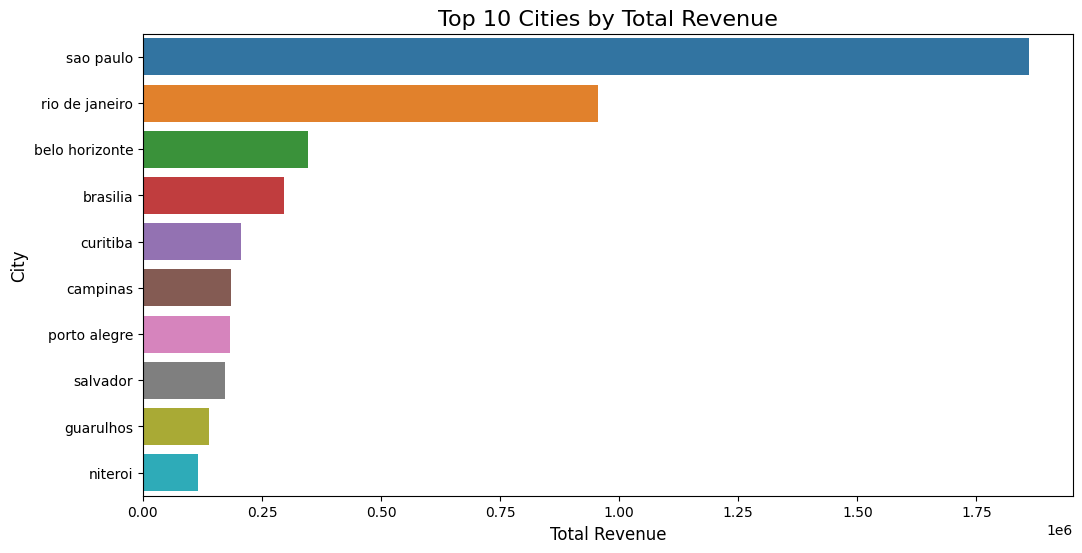

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


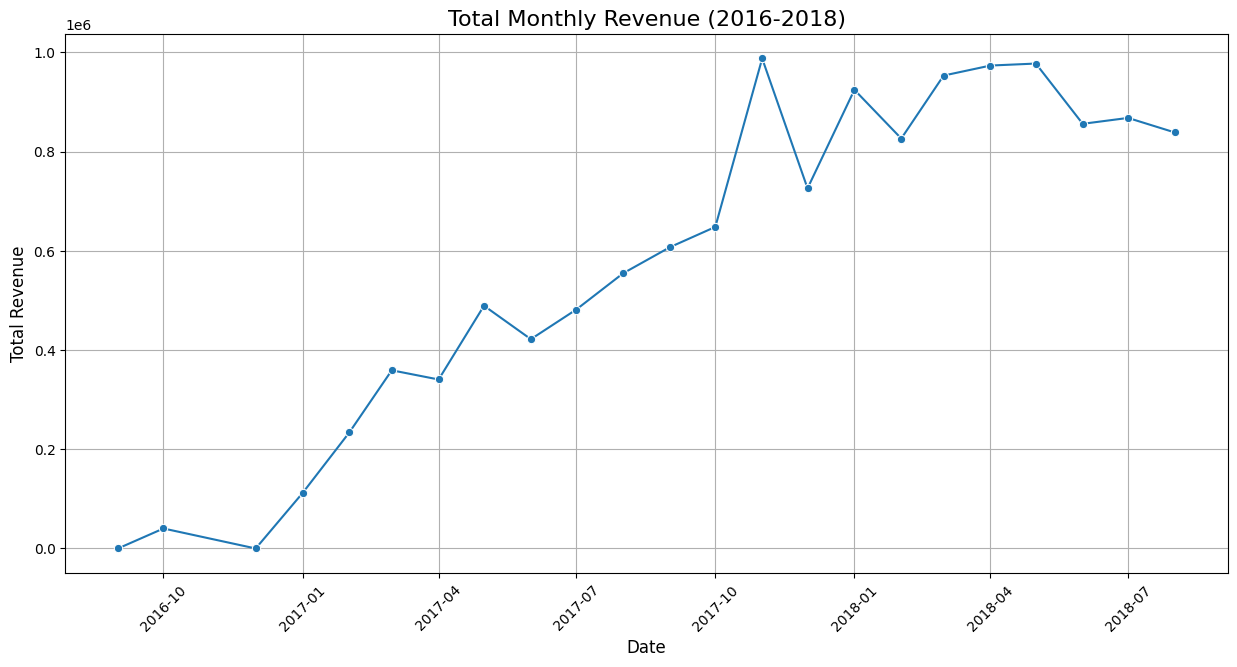

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

top_cities_pandas = top_10_cities_by_revenue.toPandas()
plt.figure(figsize=(12, 6)) 
sns.barplot(x="total_revenue", y="customer_city", data=top_cities_pandas, orient='h')


plt.title('Top 10 Cities by Total Revenue', fontsize=16)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.show() 


revenue_by_month_pandas = revenue_by_month.orderBy("year", "month").toPandas()
# Create a proper date column for plotting
revenue_by_month_pandas['date'] = pd.to_datetime(revenue_by_month_pandas['year'].astype(str) + '-' + revenue_by_month_pandas['month'].astype(str))


plt.figure(figsize=(15, 7)) 
sns.lineplot(x='date', y='total_revenue', data=revenue_by_month_pandas, marker='o')


plt.title('Total Monthly Revenue (2016-2018)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45) 
plt.grid(True) 
plt.show() 


In [19]:
from pyspark.sql.functions import collect_list, size, col
print("Starting to group products by order...")
basket_data = final_df.groupBy("order_id") \
                      .agg(collect_list("product_id").alias("items"))

print("Grouping complete!")
print("\n--- عينة من بيانات سلة المشتريات (كل صف هو طلبية واحدة) ---")
basket_data.select("items").show(10, truncate=False)
orders_with_multiple_items = basket_data.filter(size(col("items")) > 1)
print(f"\nمعلومة إضافية: عدد الطلبيات التي تحتوي على أكثر من منتج واحد هو: {orders_with_multiple_items.count()}")

Starting to group products by order...
Grouping complete!

--- عينة من بيانات سلة المشتريات (كل صف هو طلبية واحدة) ---


+------------------------------------------------------------------------------------------------------+
|items                                                                                                 |
+------------------------------------------------------------------------------------------------------+
|[e5f2d52b802189ee658865ca93d83a8f]                                                                    |
|[ac6c3623068f30de03045865e4e10089]                                                                    |
|[8d4f2bb7e93e6710a28f34fa83ee7d28]                                                                    |
|[99a4788cb24856965c36a24e339b6058]                                                                    |
|[4fa33915031a8cde03dd0d3e8fb27f01]                                                                    |
|[1c05e0964302b6cf68ca0d15f326c6ba]                                                                    |
|[e95ee6822b66ac6058e2e4aff656071a, e95ee6822b66ac6058e


معلومة إضافية: عدد الطلبيات التي تحتوي على أكثر من منتج واحد هو: 9635


In [ ]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import array_distinct

cleaned_basket_data = basket_data.withColumn("items", array_distinct(col("items")))

print("Training the FP-Growth model with relaxed settings...")
fpGrowth_relaxed = FPGrowth(itemsCol="items", minSupport=0.0005, minConfidence=0.01)
model_relaxed = fpGrowth_relaxed.fit(cleaned_basket_data)
print("Model training complete!")



print("\n--- Association Rules found by the relaxed model ---")
model_relaxed.associationRules.show(20, truncate=False)



print("\n--- Frequently purchased itemsets (relaxed model) ---")
model_relaxed.freqItemsets.show(20, truncate=False)


Training the FP-Growth model with relaxed settings...


Model training complete!

--- Association Rules found by the relaxed model ---


+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+


--- Frequently purchased itemsets (relaxed model) ---
+----------------------------------+----+
|items                             |freq|
+----------------------------------+----+
|[97017430754804328eb9597b7f85da03]|65  |
|[f35927953ed82e19d06ad3aac2f06353]|54  |
|[7e0dc102074f8285580c9777f79c90cf]|62  |
|[2a5806f10d0f00e5ad032dd2e3c8806e]|51  |
|[d04857e7b4b708ee8b8b9921163edba3]|82  |
|[2028bf1b01cafb2d2b1901fca4083222]|128 |
|[36f60d45225e60c7da4558b070ce4b60]|110 |
|[154e7e31ebfa092203795c972e5804a6]|262 |
|[b532349fe46b38fbc7bb3914c1bdae07]|74  |
|[d5991653e037ccb7af6ed7d94246b249]|57  |
|[b0961721fd839e9982420e807758a2a6]|94  |
|[19c91ef95d509ea33eda93495c4d3481]|153 |
|[06c6e01186af8b98ee1fc9e01f9471e9]|55  |
|[dbb67791e405873b259e4656bf971246]|63  |
|[d696750e550fd0f733979dd7e5dff921]|52

In [ ]:
from pyspark.sql.functions import col, max, countDistinct, sum, datediff, lit
from pyspark.sql import Window

latest_date = full_df.select(max("order_purchase_timestamp")).first()[0]
current_date = latest_date.replace(day=latest_date.day + 1)

print(f"The 'current date' for Recency calculation is: {current_date}")

rfm_intermediate = full_df.groupBy("customer_id").agg(
    
    sum("price").alias("monetary"),
   
    countDistinct("order_id").alias("frequency"),
    
   
    max("order_purchase_timestamp").alias("last_purchase_date")
)

rfm_df = rfm_intermediate.withColumn(
    "recency",
    datediff(lit(current_date), col("last_purchase_date"))
)

print("\n--- RFM metrics for each customer ---")
rfm_df.select("customer_id", "recency", "frequency", "monetary").show(10)



The 'current date' for Recency calculation is: 2018-08-30 15:00:37

--- RFM metrics for each customer ---


+--------------------+-------+---------+--------+
|         customer_id|recency|frequency|monetary|
+--------------------+-------+---------+--------+
|0721e1c4b91bc6ded...|    322|        1|    89.9|
|36a1aa63bf2ebcd49...|    228|        1|   86.99|
|80447be02d8f3f3f3...|    216|        1|    25.9|
|6e48d7670ed33717b...|    162|        1|  116.99|
|72ecfc69f7d90359d...|    170|        1|   110.0|
|6f8b4eeaba59ef3fa...|    159|        1|   251.9|
|a56b03f5e6015f1a5...|    430|        1|    49.9|
|42da09831872a4ecc...|     36|        1|    76.0|
|6f804e6a8f98ba0d1...|    421|        1|    34.9|
|da14d636fdbf0cf7f...|     97|        1|   28.99|
+--------------------+-------+---------+--------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import ntile
from pyspark.sql import Window
recency_window = Window.orderBy(col("recency").desc())

frequency_window = Window.orderBy(col("frequency").asc())
monetary_window = Window.orderBy(col("monetary").asc())
rfm_scores = rfm_df.withColumn("r_score", ntile(4).over(recency_window)) \
                   .withColumn("f_score", ntile(4).over(frequency_window)) \
                   .withColumn("m_score", ntile(4).over(monetary_window))

print("--- RFM Scores for each customer ---")
rfm_scores.select("customer_id", "recency", "frequency", "monetary", "r_score", "f_score", "m_score").show(10)


--- RFM Scores for each customer ---


25/09/02 15:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 1

+--------------------+-------+---------+--------+-------+-------+-------+
|         customer_id|recency|frequency|monetary|r_score|f_score|m_score|
+--------------------+-------+---------+--------+-------+-------+-------+
|9f9d249355f63c5c1...|    128|        1|    0.85|      3|      3|      1|
|161b6d415e8b3413c...|    128|        1|    0.85|      3|      3|      1|
|a790343ca6f3fee08...|      5|        1|     2.2|      4|      4|      1|
|184e8e8e48937145e...|    351|        1|    2.29|      1|      1|      1|
|d2c63ad286e3ca9dd...|    602|        1|     2.9|      1|      1|      1|
|5ac9fcc9259df95cf...|    209|        1|    2.99|      3|      3|      1|
|77a34d46f6ebd1dcb...|     58|        1|     3.0|      4|      4|      1|
|deaf712a6d3021707...|     20|        1|     3.0|      4|      4|      1|
|40ada5e3dc4b3c488...|    432|        1|    3.49|      1|      1|      1|
|8e4bd65db637116b6...|     70|        1|     3.5|      4|      4|      1|
+--------------------+-------+--------

In [ ]:
from pyspark.sql.functions import concat, when


rfm_segments = rfm_scores.withColumn(
    "rfm_segment",
    concat(col("r_score"), col("f_score"), col("m_score"))
)

final_rfm = rfm_segments.withColumn(
    "segment_name",
    when(col("rfm_segment").isin("444", "443", "434", "344"), "أفضل العملاء (Champions)")
    .when(col("rfm_segment").isin("333", "334", "343", "433"), "عملاء مخلصون (Loyal Customers)")
    .when(col("rfm_segment").isin("441", "442", "431", "432", "422", "421", "341", "342", "331", "332"), "عملاء واعدون (Potential Loyalists)")
    .when(col("rfm_segment").isin("411", "412", "423"), "عملاء جدد (New Customers)")
    .when(col("rfm_segment").isin("244", "243", "234", "144", "143", "134"), "عملاء معرضون للخطر (At Risk)")
    .when(col("rfm_segment").isin("111", "112", "121", "122", "211", "212", "221", "222"), "عملاء خاملون (Hibernating)")
    .when(col("rfm_segment").isin("133", "132", "142", "241", "231", "242", "232"), "عملاء على وشك الضياع (About to Sleep)")
    .otherwise("آخرون (Others)") 
)

print("--- Final Customer Segments ---")
final_rfm.select("customer_id", "recency", "frequency", "monetary", "rfm_segment", "segment_name").show(20)
print("\n--- Customer Count by Segment ---")
final_rfm.groupBy("segment_name").count().orderBy(col("count").desc()).show()



--- Final Customer Segments ---


25/09/02 15:06:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 1

+--------------------+-------+---------+--------+-----------+--------------------+
|         customer_id|recency|frequency|monetary|rfm_segment|        segment_name|
+--------------------+-------+---------+--------+-----------+--------------------+
|9f9d249355f63c5c1...|    128|        1|    0.85|        331|عملاء واعدون (Pot...|
|161b6d415e8b3413c...|    128|        1|    0.85|        331|عملاء واعدون (Pot...|
|a790343ca6f3fee08...|      5|        1|     2.2|        441|عملاء واعدون (Pot...|
|184e8e8e48937145e...|    351|        1|    2.29|        111|عملاء خاملون (Hib...|
|d2c63ad286e3ca9dd...|    602|        1|     2.9|        111|عملاء خاملون (Hib...|
|5ac9fcc9259df95cf...|    209|        1|    2.99|        331|عملاء واعدون (Pot...|
|77a34d46f6ebd1dcb...|     58|        1|     3.0|        441|عملاء واعدون (Pot...|
|deaf712a6d3021707...|     20|        1|     3.0|        441|عملاء واعدون (Pot...|
|40ada5e3dc4b3c488...|    432|        1|    3.49|        111|عملاء خاملون (Hib...|
|8e4

25/09/02 15:06:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:06:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 1

+--------------------+-----+
|        segment_name|count|
+--------------------+-----+
|عملاء خاملون (Hib...|24334|
|عملاء واعدون (Pot...|23906|
|      آخرون (Others)|23906|
|عملاء مخلصون (Loy...|12235|
|أفضل العملاء (Cha...|12097|
+--------------------+-----+



In [ ]:
output_path = "/kaggle/working/"

print(f"Starting to save final DataFrames to CSV files in: {output_path}")
final_rfm.repartition(1).write.csv(output_path + "rfm_customer_segments", header=True, mode="overwrite")
final_rfm.groupBy("segment_name").count().orderBy(col("count").desc()) \
    .repartition(1).write.csv(output_path + "segment_counts", header=True, mode="overwrite")
top_10_cities_by_revenue.repartition(1).write.csv(output_path + "top_cities_revenue", header=True, mode="overwrite")
revenue_by_month.repartition(1).write.csv(output_path + "monthly_revenue", header=True, mode="overwrite")
negative_margin_orders = financial_df.filter(col("margin_percentage") < 0)
negative_margin_orders.repartition(1).write.csv(output_path + "negative_margin_orders", header=True, mode="overwrite")
print("\nAll files have been saved successfully!")
print("You can now find them in the 'Output' section of your Kaggle notebook.")



Starting to save final DataFrames to CSV files in: /kaggle/working/


25/09/02 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/09/02 1


All files have been saved successfully!
You can now find them in the 'Output' section of your Kaggle notebook.
